## Konflikty zbrojne na świecie w 2022 roku
#### Anna Ostrowska - HW6
Korzystam z danych o konfliktach zbrojnych w latach 1946-2022 pobranych ze strony: https://ucdp.uu.se/downloads/index.html#armedconflict:
,,A conflict-year dataset with information on armed conflict where at least one party is the government of a state in the time period 1946-2022."

Wykorzystam jedyne dane z 2022 roku, poniewaz jest ich na tyle dużo, ze nie widac nic na wizualizacji, jak weźmiemy wszystkie lata.

inne źródła:

• Davies, Shawn, Therese Pettersson & Magnus Öberg (2023). Organized violence 1989-2022 and the return of conflicts between states?. Journal of Peace Research 60(4).
• Gleditsch, Nils Petter, Peter Wallensteen, Mikael Eriksson, Margareta Sollenberg, and Håvard Strand (2002) Armed Conflict 1946-2001: A New Dataset. Journal of Peace Research 39(5).

In [79]:
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd

In [228]:
conflicts = pd.read_csv("conflicts.csv", encoding='latin-1')
conflicts = conflicts.copy()
ids = pd.read_csv("ids.csv", encoding='latin-1')

In [229]:
#tylko od 2000 roku
conflicts = conflicts[conflicts['year'] == 2022]

In [230]:
#wybieram interesujace mnie kolumny z ramek danych
conflicts = conflicts[['side_a_id', 'side_b_id']]

In [231]:
ids=ids[["ActorId","NameData"]]

In [232]:
#skracam nazwy panstw, np z ,,Government of Italy'' do ,,Italy''
def remove_prefix(value):
    if value.startswith('Government of '):
        return value[len('Government of '):]
    else:
        return value

ids['NameData'] = ids['NameData'].apply(remove_prefix)

In [233]:
#niektore konflikty mialy po kilka panstw na stronie 
#(panstwa a,b,c,d przeciwko panstwom e,f,g. W tabeli jest to wpisane jako lista panstw, rozdzielmy to na osobne wiersze,
#poniewaz interesuja nas tylko ktore panstwa toczyly konflikty zbrojne przeciwko sobie)
conflicts['side_a_id']=conflicts['side_a_id'].astype(str)
conflicts['side_a_id'] = conflicts['side_a_id'].str.split(',')
conflicts = conflicts.explode('side_a_id')

In [234]:
conflicts['side_b_id']=conflicts['side_b_id'].astype(str)
conflicts['side_b_id'] = conflicts['side_b_id'].str.split(',')
conflicts = conflicts.explode('side_b_id')

In [235]:
conflicts['side_b_id']=conflicts['side_b_id'].astype(str)
conflicts['side_b_id'] = conflicts['side_b_id'].str.split(',')
conflicts = conflicts.explode('side_b_id')

In [236]:
#aby zmergowac zmienmy typy danych z id na inty
ids['ActorId'] = ids['ActorId'].astype(int)
conflicts['side_a_id']=conflicts['side_a_id'].astype(int)
conflicts['side_b_id']=conflicts['side_b_id'].astype(int)

In [237]:
merged1 = pd.merge(conflicts, ids, right_on='ActorId', left_on='side_a_id', how='left')
merged2 = pd.merge(conflicts, ids, right_on='ActorId', left_on='side_b_id', how='left')
merged1["side_a"]=merged1["NameData"]
merged2["side_b"]=merged2["NameData"]
merged = pd.concat([merged1, merged2], axis=1)

In [238]:
merged = merged[['side_a', 'side_b']]

In [239]:
merged

,side_a,side_b
0,Philippines,CPP
1,Myanmar (Burma),KNU
2,Myanmar (Burma),PSLF
3,Myanmar (Burma),NUG
4,Myanmar (Burma),ULA
...,...,...
59,Iran,Israel
60,DR Congo (Zaire),IS
61,Benin,JNIM
62,Uganda,IS


In [240]:
merged = merged.groupby(['side_a', 'side_b']).size().reset_index(name='conflicts_count')
merged.columns = ['source', 'target', 'weight']
merged

,source,target,weight
0,Afghanistan,AFF,1
1,Afghanistan,IS,1
2,Afghanistan,NRF,1
3,Angola,FLEC-FAC-TN,1
4,Azerbaijan,Republic of Artsakh,1
...,...,...,...
59,Togo,JNIM,1
60,Turkey,PKK,1
61,Uganda,IS,1
62,Ukraine,DPR,1


In [268]:
import matplotlib.lines as mlines

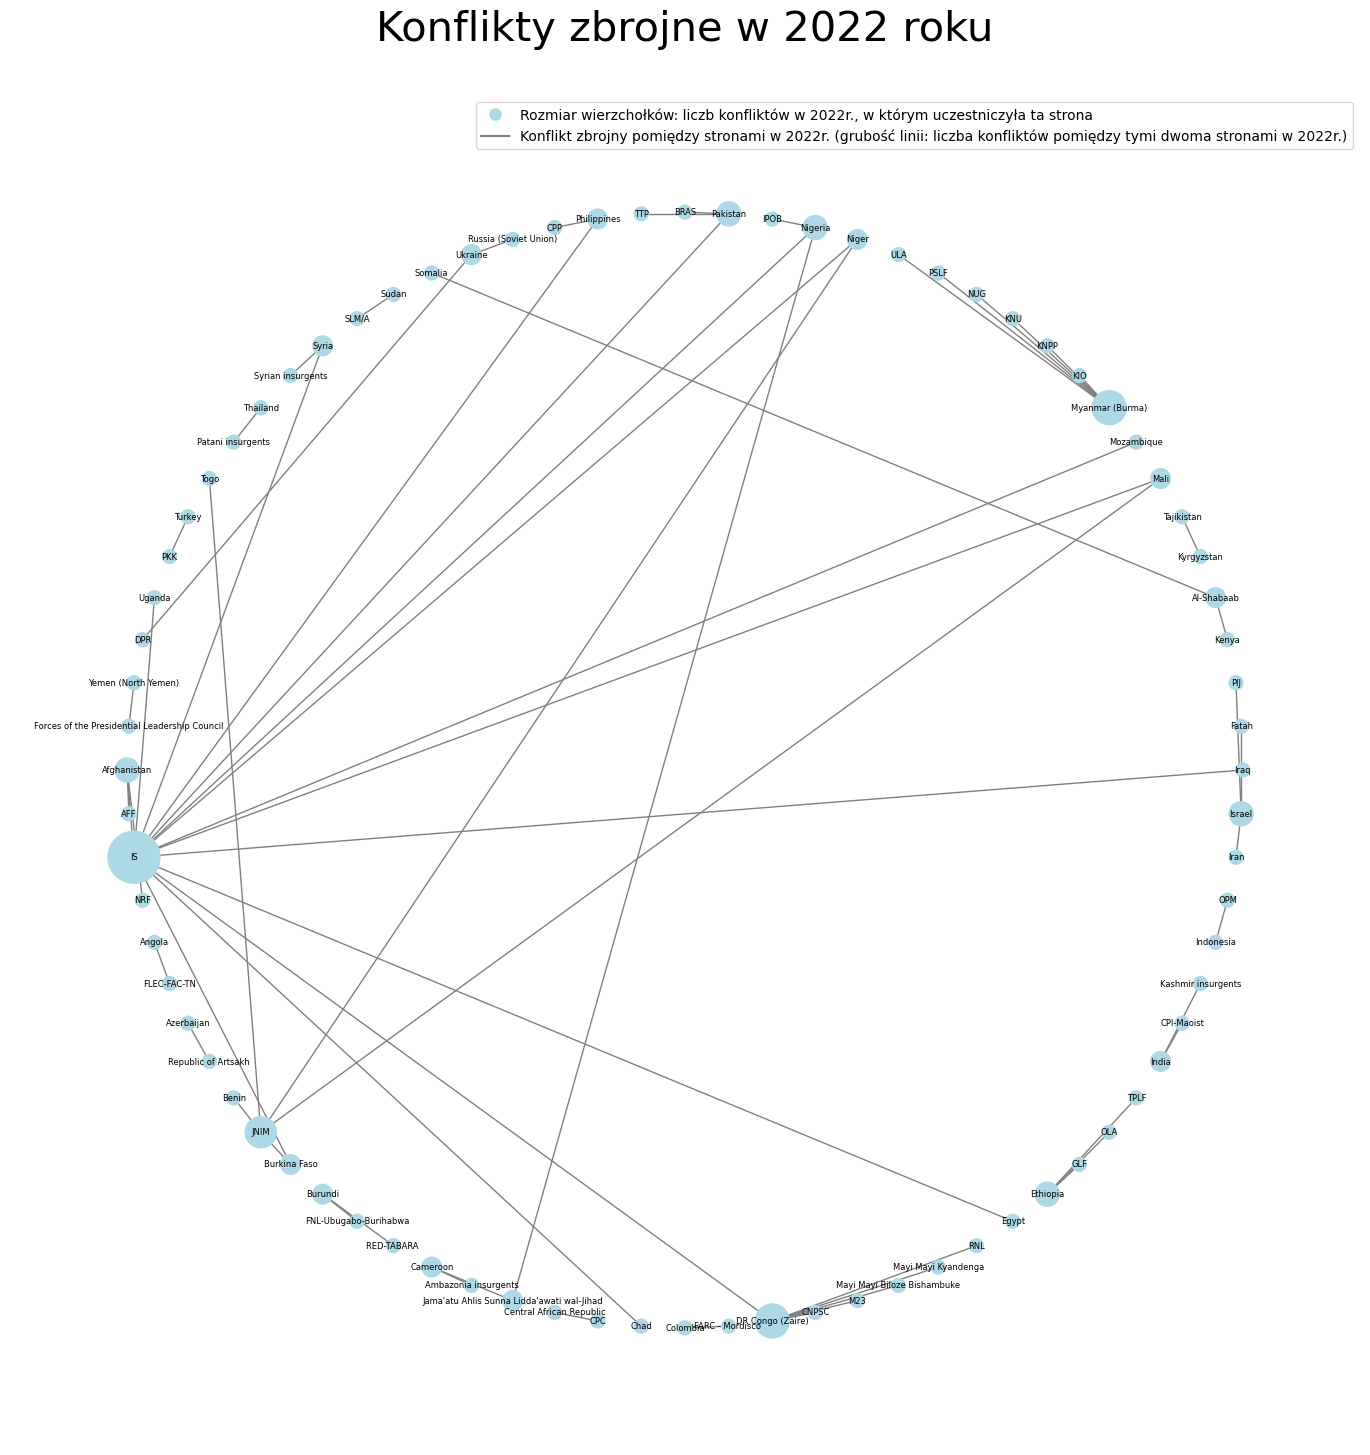

In [285]:
graph = nx.from_pandas_edgelist(merged, edge_attr=True)
graph.nodes(data=True)
graph.edges(data=True)
plt.figure(figsize=(13.5,13.5))

degrees = dict(graph.degree())
pos = nx.shell_layout(graph)
nx.draw(graph, pos=pos,with_labels=True, node_size=[degrees[node] * 100 for node in graph.nodes],
    width=[e[2]["weight"] for e in graph.edges(data=True)],  font_size=6, node_color='lightblue', edge_color='grey') 
#tworze graf, im wiecej konfliktow pomiedzy dwoma stronami, tym grubsza linia i im wiecej konfliktow toczyla dana strona w sumie, tym wiekszy jej wezel)
legend_labels_nodes = {'node_size': 'Rozmiar wierzchołków: liczb konfliktów w 2022r., w którym uczestniczyła ta strona',
                      'weight': 'Konflikt zbrojny pomiędzy stronami w 2022r. (grubość linii: liczba konfliktów pomiędzy tymi dwoma stronami w 2022r.)'}
legend_handles_nodes = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                                   markersize=10), mlines.Line2D([], [], color='grey', linestyle='-')]
plt.legend(handles=legend_handles_nodes, labels=legend_labels_nodes.values())

plt.title('Konflikty zbrojne w 2022 roku\n', fontsize=30)
plt.savefig('conflicts_2022.png')
plt.show()